## AMR 2 Battery Analysis

In [1]:
import os
import csv
from datetime import datetime

def combine_battery_trend_csvs(base_dir, output_file):
    date_folders = []
    
    for folder_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue
            
        parts = folder_name.split('-')
        if len(parts) != 3:
            continue
            
        try:
            year = int(parts[0])
            month = int(parts[1])
            day = int(parts[2])
            date_obj = datetime(year, month, day).date()
            csv_path = os.path.join(folder_path, 'batterry_thrend.csv')
            if os.path.isfile(csv_path):
                date_folders.append((date_obj, folder_name, csv_path))
        except (ValueError, TypeError):
            continue
            
    date_folders.sort(key=lambda x: x[0])
    
    with open(output_file, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['date', 'time', 'log_level', 'status', 'percent', 'volt', 'current'])
        
        for date_obj, folder_name, csv_path in date_folders:
            with open(csv_path, 'r') as infile:
                reader = csv.reader(infile)
                for row in reader:
                    if len(row) < 6 or not row[0].strip():
                        continue
                    writer.writerow([folder_name] + row[:6])

# Example usage:
combine_battery_trend_csvs('D:/amr/battery_log02', 'combined_battery_trend_log02.csv')

In [2]:
import csv

input_filename = "combined_battery_trend_log02.csv"
output_filename = "cleaned_combined_battery_trend_log02.csv"

with open(input_filename, 'r', newline='', encoding='utf-8') as infile, \
     open(output_filename, 'w', newline='', encoding='utf-8') as outfile:

    csv_reader = csv.reader(infile)
    csv_writer = csv.writer(outfile)

    for row in csv_reader:
        if len(row) == 7:
            csv_writer.writerow(row)

In [3]:
import duckdb

# Connect to DuckDB (in-memory database)
con = duckdb.connect()

# Register CSV as a virtual table, skipping rows with errors
con.execute("""
    CREATE VIEW my_data AS
    SELECT * 
    FROM read_csv_auto(
        'cleaned_combined_battery_trend_log02.csv',
        HEADER=True,
        SAMPLE_SIZE=100000,
        ignore_errors=1  -- Skip problematic rows
    )
""")

# Execute query
result = con.execute("SELECT * FROM my_data")

# Fetch results to pandas
df_result = result.df()
#print(df_result)
df_result

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,date,time,log_level,status,percent,volt,current
0,2025-04-30,02:06.5,INFO,CHARGE,79.019999,22.380400,3.94
1,2025-04-30,02:07.5,INFO,CHARGE,79.078299,22.381565,3.94
2,2025-04-30,02:08.5,INFO,CHARGE,79.136598,22.382732,3.94
3,2025-04-30,02:09.5,INFO,CHARGE,79.253203,22.385063,3.94
4,2025-04-30,02:10.5,INFO,CHARGE,79.311502,22.386230,3.94
...,...,...,...,...,...,...,...
2742397,2025-06-06,2025-06-06 10:13:25.410698,WARN,DISCHARGE,56.866002,21.937321,0.00
2742398,2025-06-06,2025-06-06 10:13:26.410740,WARN,DISCHARGE,56.866002,21.937321,0.00
2742399,2025-06-06,2025-06-06 10:13:27.410666,WARN,DISCHARGE,56.924301,21.938486,0.00
2742400,2025-06-06,2025-06-06 10:13:28.410656,WARN,DISCHARGE,56.924301,21.938486,0.00


In [4]:
import pandas as pd

# Convert to UTC datetime with error coercion
df_result['time'] = pd.to_datetime(
    df_result['time'], 
    format='mixed', 
    errors='coerce',
    utc=True  # Explicitly handle timezones by converting to UTC
)

# Remove rows with conversion errors
df_result = df_result.dropna(subset=['time'])

# Optional: Convert to timezone-naive UTC if needed
# df_result['time'] = df_result['time'].dt.tz_localize(None)

df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742402 entries, 0 to 2742401
Data columns (total 7 columns):
 #   Column     Dtype              
---  ------     -----              
 0   date       datetime64[us]     
 1   time       datetime64[ns, UTC]
 2   log_level  object             
 3   status     object             
 4   percent    float64            
 5   volt       float64            
 6   current    float64            
dtypes: datetime64[ns, UTC](1), datetime64[us](1), float64(3), object(2)
memory usage: 146.5+ MB


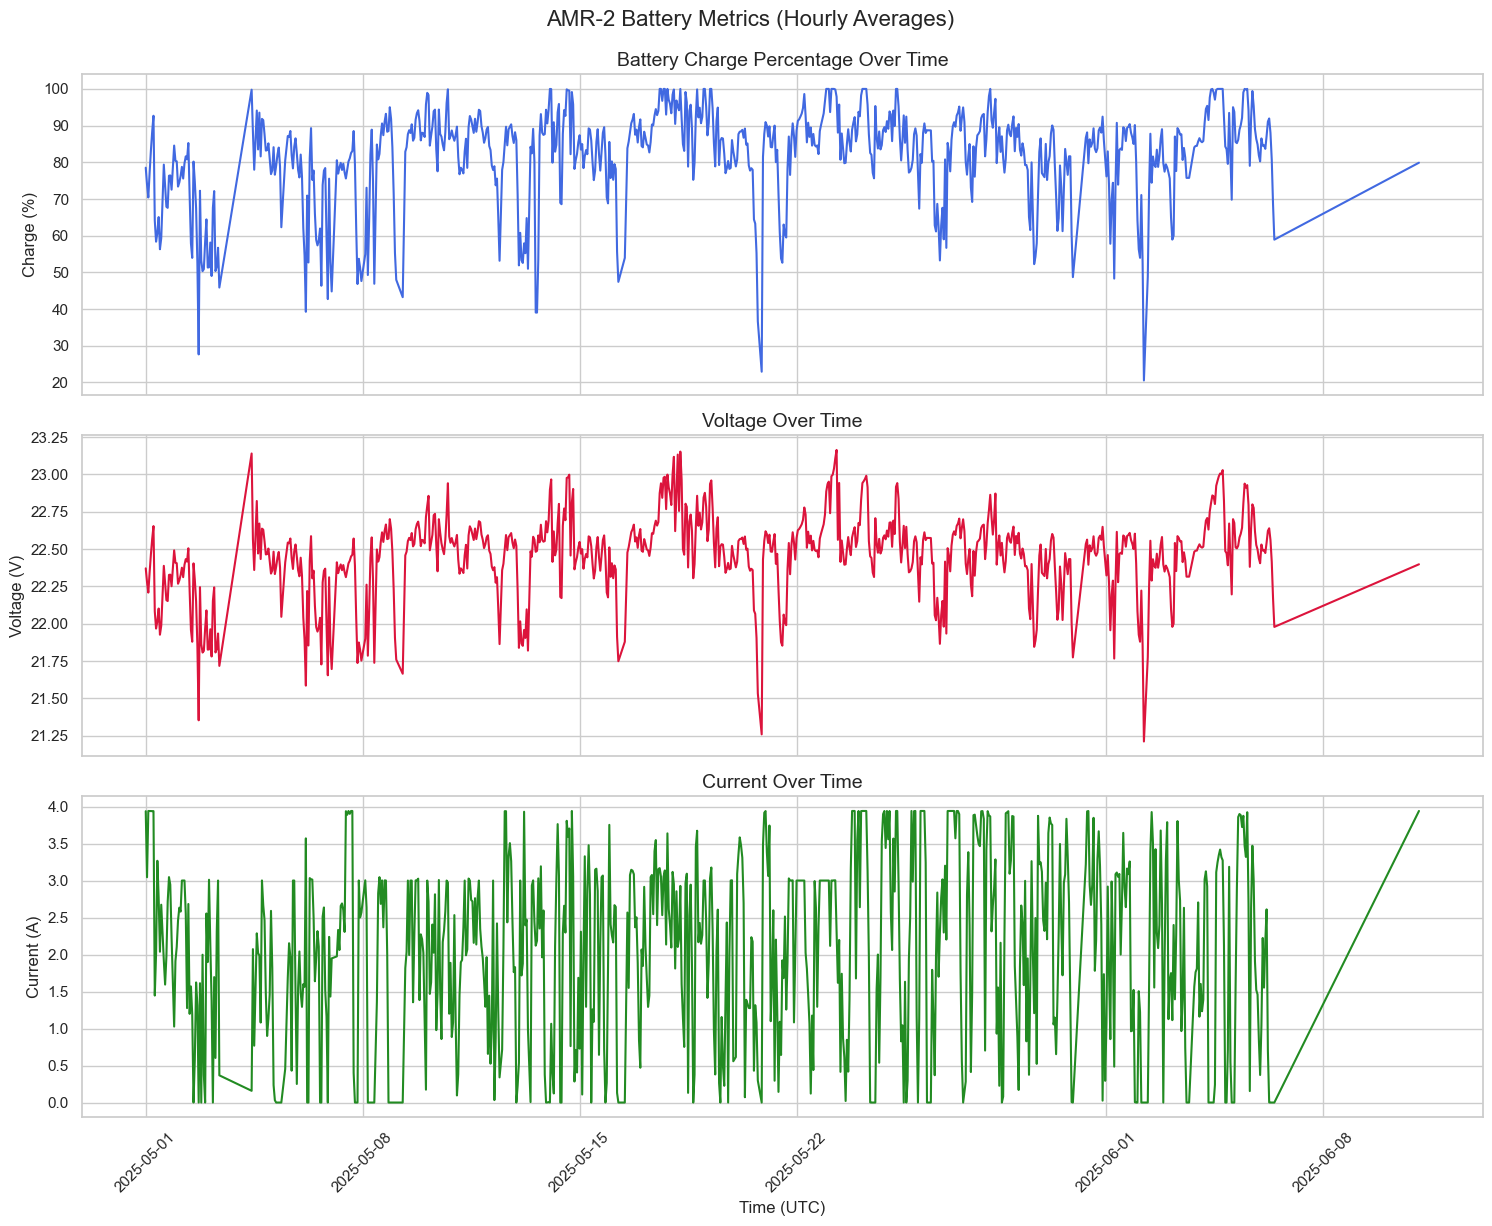

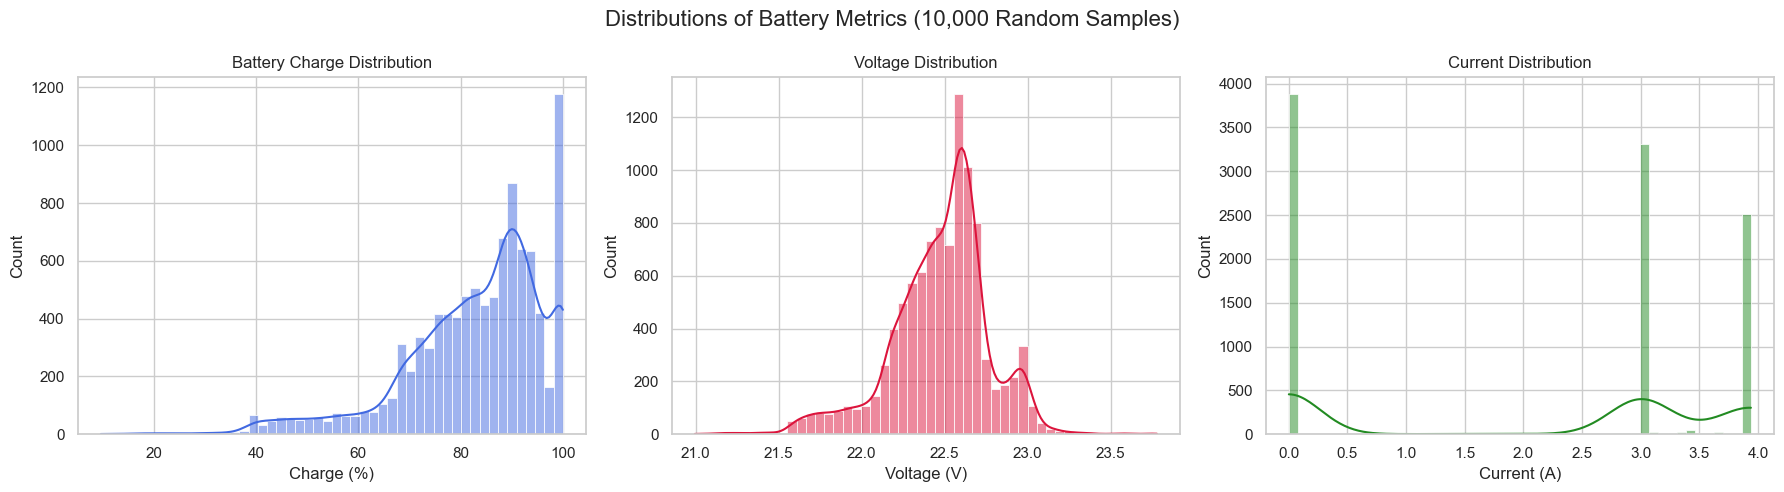

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set Seaborn style
sns.set(style="whitegrid")

# 1. Resample data for time series (hourly averages)
# ------------------------------------------------
# Use 'time' column as datetime index
df_time = df_result.set_index('time')
resampled = df_time[['percent', 'volt', 'current']].resample('h').mean().reset_index()

# 2. Time Series Plots
# --------------------
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Battery Percentage
sns.lineplot(data=resampled, x='time', y='percent', ax=axes[0], color='royalblue')
axes[0].set_title('Battery Charge Percentage Over Time', fontsize=14)
axes[0].set_ylabel('Charge (%)')

# Voltage
sns.lineplot(data=resampled, x='time', y='volt', ax=axes[1], color='crimson')
axes[1].set_title('Voltage Over Time', fontsize=14)
axes[1].set_ylabel('Voltage (V)')

# Current
sns.lineplot(data=resampled, x='time', y='current', ax=axes[2], color='forestgreen')
axes[2].set_title('Current Over Time', fontsize=14)
axes[2].set_ylabel('Current (A)')
axes[2].set_xlabel('Time (UTC)')

# Format x-axis dates
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle('AMR-2 Battery Metrics (Hourly Averages)', y=1.02, fontsize=16)
plt.show()

# 3. Distribution Plots (using 10,000 random samples)
# ---------------------------------------------------
sample_df = df_result.sample(n=10000, random_state=1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Battery Percentage Distribution
sns.histplot(sample_df['percent'], bins=50, kde=True, ax=axes[0], color='royalblue')
axes[0].set_title('Battery Charge Distribution')
axes[0].set_xlabel('Charge (%)')

# Voltage Distribution
sns.histplot(sample_df['volt'], bins=50, kde=True, ax=axes[1], color='crimson')
axes[1].set_title('Voltage Distribution')
axes[1].set_xlabel('Voltage (V)')

# Current Distribution
sns.histplot(sample_df['current'], bins=50, kde=True, ax=axes[2], color='forestgreen')
axes[2].set_title('Current Distribution')
axes[2].set_xlabel('Current (A)')

plt.suptitle('Distributions of Battery Metrics (10,000 Random Samples)', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

# Set Seaborn style
sns.set(style="whitegrid")

# Create figure with GridSpec layout
fig = plt.figure(figsize=(18, 22))
gs = gridspec.GridSpec(4, 3, height_ratios=[2, 2, 2, 1.5], figure=fig)

# 1. Prepare data
# ----------------
df_time = df_result.set_index('time')
resampled = df_time[['percent', 'volt', 'current']].resample('h').mean().reset_index()
sample_df = df_result.sample(n=10000, random_state=1)

# 2. Time Series Plots
# --------------------
# Battery Percentage
ax0 = fig.add_subplot(gs[0, :])
sns.lineplot(data=resampled, x='time', y='percent', ax=ax0, color='royalblue')
ax0.set_title('Battery Charge Percentage Over Time', fontsize=14)
ax0.set_ylabel('Charge (%)')
ax0.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Voltage
ax1 = fig.add_subplot(gs[1, :], sharex=ax0)
sns.lineplot(data=resampled, x='time', y='volt', ax=ax1, color='crimson')
ax1.set_title('Voltage Over Time', fontsize=14)
ax1.set_ylabel('Voltage (V)')
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Current
ax2 = fig.add_subplot(gs[2, :], sharex=ax0)
sns.lineplot(data=resampled, x='time', y='current', ax=ax2, color='forestgreen')
ax2.set_title('Current Over Time', fontsize=14)
ax2.set_ylabel('Current (A)')
ax2.set_xlabel('Time (UTC)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# 3. Distribution Plots
# ---------------------
# Battery Percentage Distribution
ax3 = fig.add_subplot(gs[3, 0])
sns.histplot(sample_df['percent'], bins=50, kde=True, ax=ax3, color='royalblue')
ax3.set_title('Battery Charge Distribution', fontsize=12)
ax3.set_xlabel('Charge (%)')

# Voltage Distribution
ax4 = fig.add_subplot(gs[3, 1])
sns.histplot(sample_df['volt'], bins=50, kde=True, ax=ax4, color='crimson')
ax4.set_title('Voltage Distribution', fontsize=12)
ax4.set_xlabel('Voltage (V)')

# Current Distribution
ax5 = fig.add_subplot(gs[3, 2])
sns.histplot(sample_df['current'], bins=50, kde=True, ax=ax5, color='forestgreen')
ax5.set_title('Current Distribution', fontsize=12)
ax5.set_xlabel('Current (A)')

# 4. Main title and layout adjustments
# ------------------------------------
plt.suptitle('AMR-2 Battery Analysis\nTime Series (Hourly Averages) and Distributions (10k Samples)', 
             fontsize=18, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)

# Save to single file
plt.savefig('amr2_battery_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

print("All plots saved to 'amr_battery_analysis.png'")

All plots saved to 'amr_battery_analysis.png'


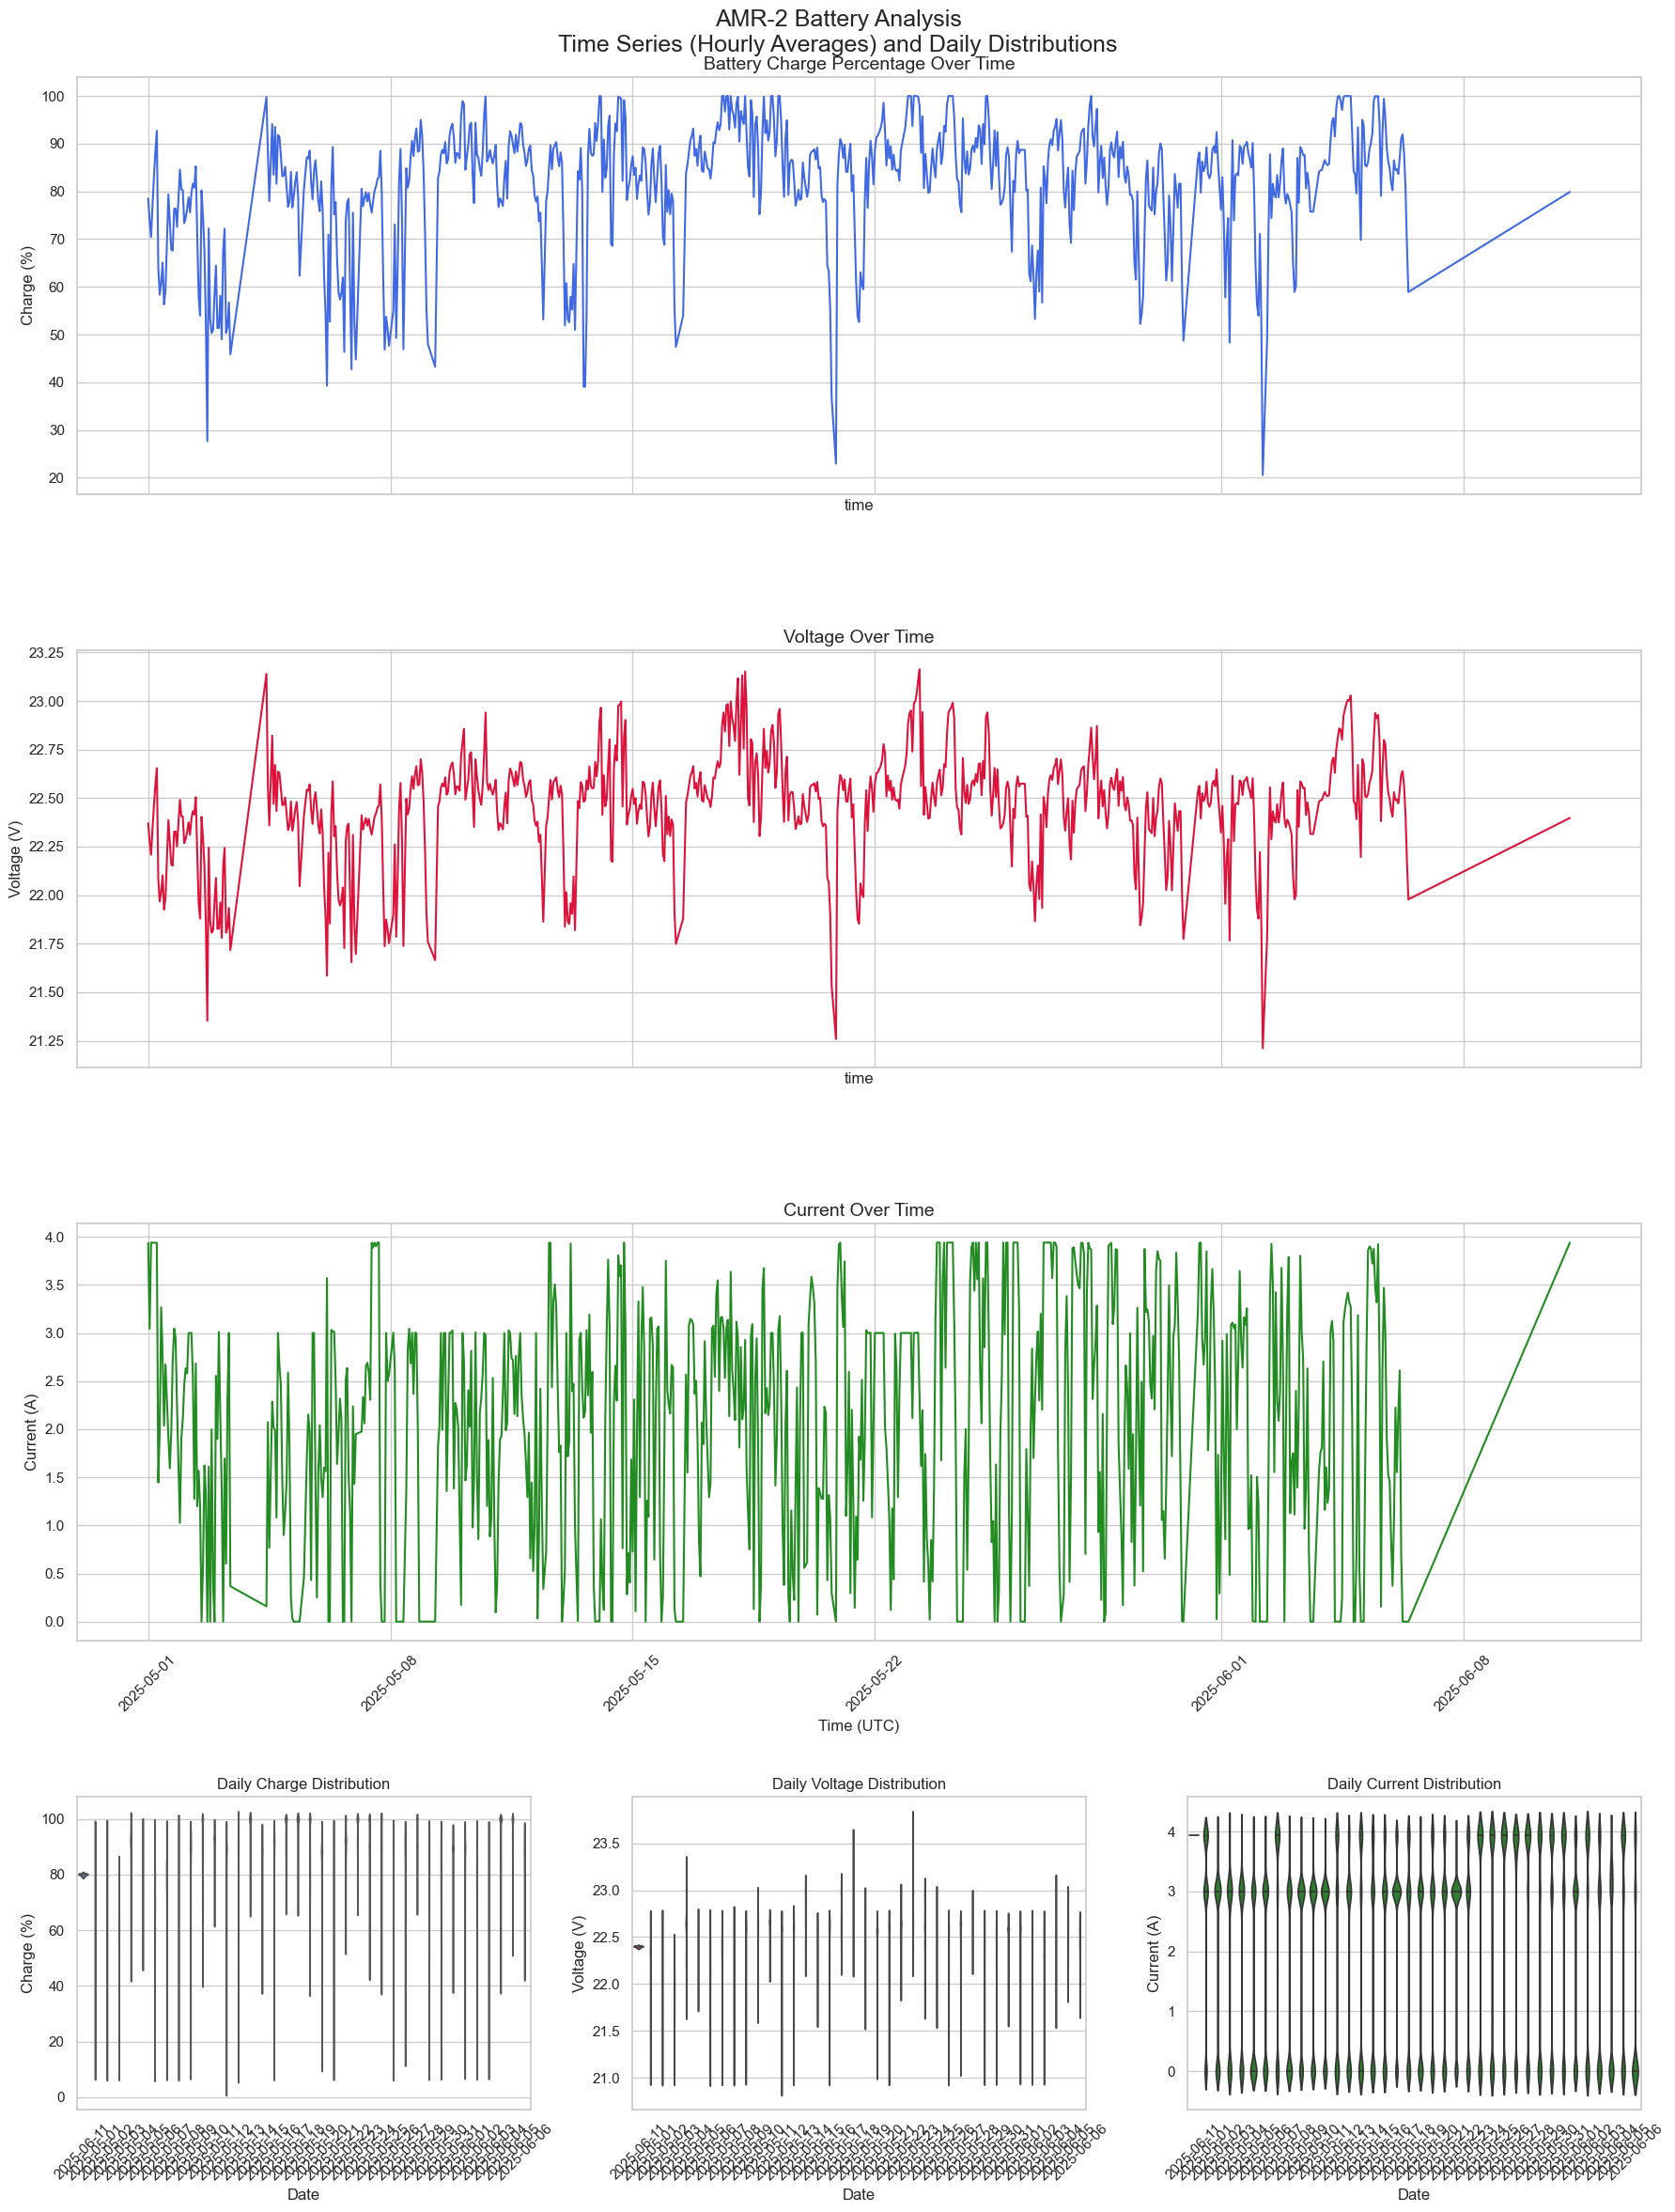

All plots saved to 'amr2_battery_full_analysis.png'


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

# Set Seaborn style
sns.set(style="whitegrid")

# Create main figure
fig = plt.figure(figsize=(18, 24))
gs = gridspec.GridSpec(4, 3, height_ratios=[2, 2, 2, 1.5], figure=fig)

# 1. Prepare data
# ----------------
# Extract date from datetime
df_result['date_only'] = df_result['time'].dt.date

# Resample for time series (hourly averages)
df_time = df_result.set_index('time')
resampled = df_time[['percent', 'volt', 'current']].resample('h').mean().reset_index()

# Sample for distributions
sample_df = df_result.sample(n=10000, random_state=1)

# 2. Time Series Plots (Top Section)
# ----------------------------------
# Battery Percentage
ax0 = fig.add_subplot(gs[0, :])
sns.lineplot(data=resampled, x='time', y='percent', ax=ax0, color='royalblue')
ax0.set_title('Battery Charge Percentage Over Time', fontsize=14)
ax0.set_ylabel('Charge (%)')
ax0.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Voltage
ax1 = fig.add_subplot(gs[1, :], sharex=ax0)
sns.lineplot(data=resampled, x='time', y='volt', ax=ax1, color='crimson')
ax1.set_title('Voltage Over Time', fontsize=14)
ax1.set_ylabel('Voltage (V)')
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

# Current
ax2 = fig.add_subplot(gs[2, :], sharex=ax0)
sns.lineplot(data=resampled, x='time', y='current', ax=ax2, color='forestgreen')
ax2.set_title('Current Over Time', fontsize=14)
ax2.set_ylabel('Current (A)')
ax2.set_xlabel('Time (UTC)')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# 3. Daily Distribution Plots (Bottom Section - 3 Columns)
# --------------------------------------------------------
# Battery Percentage Daily Distribution
ax3 = fig.add_subplot(gs[3, 0])
sns.violinplot(data=df_result, x='date_only', y='percent', ax=ax3, color='royalblue', inner="quartile")
ax3.set_title('Daily Charge Distribution', fontsize=12)
ax3.set_xlabel('Date')
ax3.set_ylabel('Charge (%)')
plt.xticks(rotation=45)

# Voltage Daily Distribution
ax4 = fig.add_subplot(gs[3, 1])
sns.violinplot(data=df_result, x='date_only', y='volt', ax=ax4, color='crimson', inner="quartile")
ax4.set_title('Daily Voltage Distribution', fontsize=12)
ax4.set_xlabel('Date')
ax4.set_ylabel('Voltage (V)')
plt.xticks(rotation=45)

# Current Daily Distribution
ax5 = fig.add_subplot(gs[3, 2])
sns.violinplot(data=df_result, x='date_only', y='current', ax=ax5, color='forestgreen', inner="quartile")
ax5.set_title('Daily Current Distribution', fontsize=12)
ax5.set_xlabel('Date')
ax5.set_ylabel('Current (A)')
plt.xticks(rotation=45)

# 4. Main title and layout adjustments
# ------------------------------------
plt.suptitle('AMR-2 Battery Analysis\nTime Series (Hourly Averages) and Daily Distributions', 
             fontsize=18, y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.4)

# Save to single file
plt.show()
plt.savefig('amr2_battery_full_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

print("All plots saved to 'amr2_battery_full_analysis.png'")

Plot saved as 'battery_metrics_distribution.png'


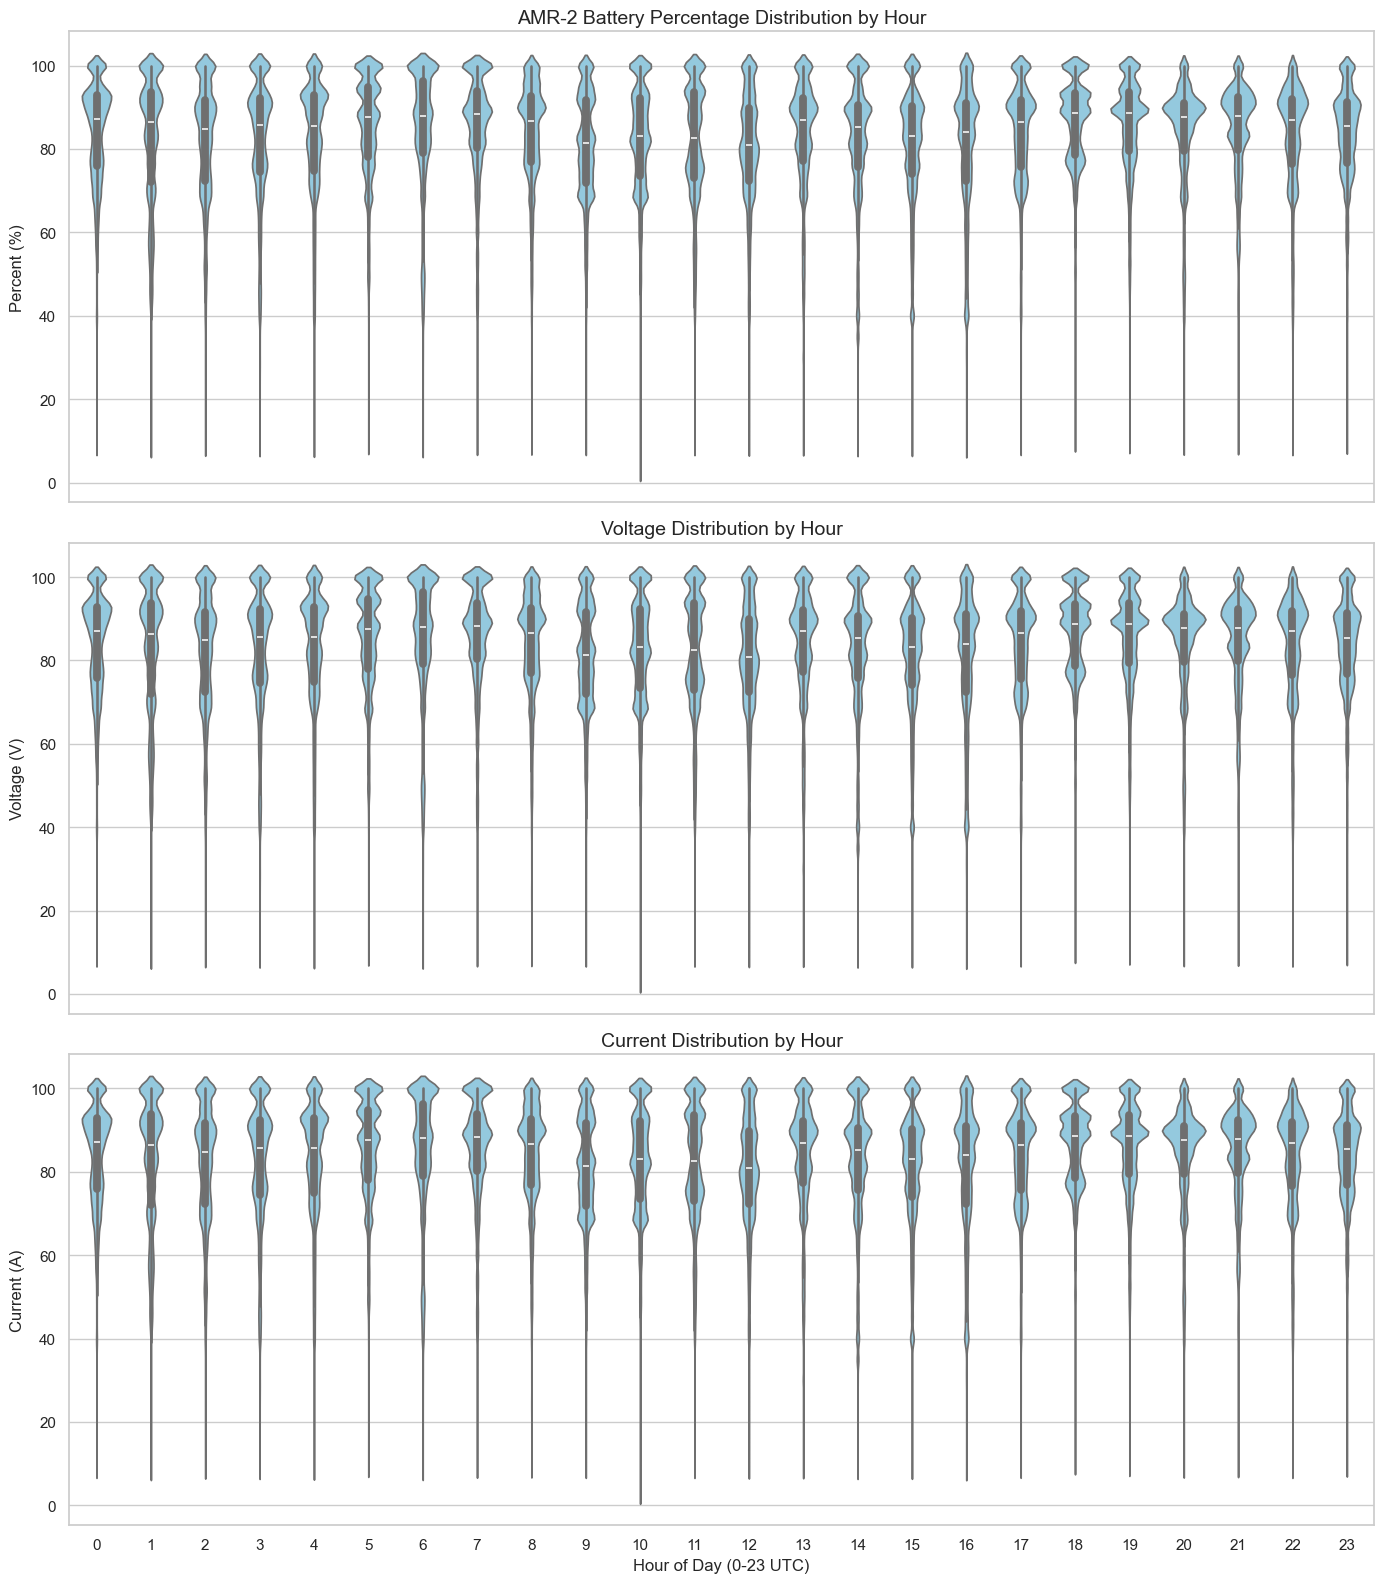

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract hour from UTC time (ignores timezone for hour extraction)
df_result['hour'] = df_result['time'].dt.hour

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

# Plot distributions
#sns.boxplot(data=df_result, x='hour', y='percent', ax=axes[0], color='skyblue', flierprops={'markersize': 1})
sns.violinplot(data=df_result, x='hour', y='percent', ax=axes[0], color='skyblue')
#sns.boxplot(data=df_result, x='hour', y='volt', ax=axes[1], color='lightgreen', flierprops={'markersize': 1})
sns.violinplot(data=df_result, x='hour', y='percent', ax=axes[1], color='skyblue')
#sns.boxplot(data=df_result, x='hour', y='current', ax=axes[2], color='salmon', flierprops={'markersize': 1})
sns.violinplot(data=df_result, x='hour', y='percent', ax=axes[2], color='skyblue')

# Customize titles and labels
axes[0].set_title('AMR-2 Battery Percentage Distribution by Hour', fontsize=14)
axes[0].set_ylabel('Percent (%)')

axes[1].set_title('Voltage Distribution by Hour', fontsize=14)
axes[1].set_ylabel('Voltage (V)')

axes[2].set_title('Current Distribution by Hour', fontsize=14)
axes[2].set_ylabel('Current (A)')
axes[2].set_xlabel('Hour of Day (0-23 UTC)')

# Save the plot before showing
plt.tight_layout()
plt.savefig('amr2_battery_metrics_distribution.png', dpi=300, bbox_inches='tight')
print("Plot saved as 'battery_metrics_distribution.png'")

# Display the plot
plt.show()

In [8]:
# Close connection
#con.close()